In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from bidict import bidict
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

tf.random.set_seed(372)

In [2]:
ENCODER = bidict({
    'A': 1, 'I': 2, 'U': 3, 'E': 4, 'O': 5,
    'KA': 6, 'KI': 7, 'KU': 8, 'KE': 9, 'KO': 10,
    'SA': 11, 'SHI': 12, 'SU': 13, 'SE': 14, 'SO': 15,
    'TA': 16, 'CHI': 17, 'TSU': 18, 'TE': 19, 'TO': 20,
    'NA': 21, 'NI': 22, 'NU': 23, 'NE': 24, 'NO': 25,
    'HA': 26, 'HI': 27, 'FU': 28, 'HE': 29, 'HO': 30,
    'MA': 31, 'MI': 32, 'MU': 33, 'ME': 34, 'MO': 35,
    'YA': 36, 'YU': 37, 'YO': 38,
    'RA': 39, 'RI': 40, 'RU': 41, 'RE': 42, 'RO': 43,
    'WA': 44, 'WO': 45, 'N': 46
})

In [3]:
labels = np.load("../data/labels.npy")
labels = np.array([ENCODER[x] for x in labels])
labels.shape

(1334,)

In [4]:
imgs = np.load("../data/imgs.npy")
imgs = imgs.astype("float32") / 255
imgs.shape

(1334, 50, 50)

In [5]:
# check out one of the images
# plt.figure()
# plt.imshow(imgs[1])
# plt.grid(False)
# plt.show()

In [6]:
imgs = np.expand_dims(imgs, -1)

In [7]:
labels, imgs = shuffle(labels, imgs)
split = .70

labels_train = labels[:int(len(labels)*split)]
labels_test = labels[int(len(labels)*split):]

imgs_train = imgs[:int(len(imgs)*split)]
imgs_test = imgs[int(len(imgs)*split):]

In [14]:
batch_size = 32
epochs = 20

model = keras.Sequential([
    keras.Input(shape=(50, 50, 1)),
    layers.Conv2D(256, kernel_size=5, activation="relu", padding='same'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.3),
    layers.Conv2D(512, kernel_size=5, activation="relu", padding='same'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.3),
    layers.Conv2D(1024, kernel_size=5, activation="relu", padding='same'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(len(ENCODER)+1, activation="softmax"),
])

In [15]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=1)
optimizer = keras.optimizers.Adam()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [16]:
model.fit(imgs_train,
          labels_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(imgs_test, labels_test),
          callbacks=[early_stopping])

Epoch 1/20
30/30 [==============================] - 222s 7s/step - loss: 3.8619 - accuracy: 0.0214 - val_loss: 3.6659 - val_accuracy: 0.0574
Epoch 2/20
30/30 [==============================] - 221s 7s/step - loss: 1.7406 - accuracy: 0.5466 - val_loss: 0.6557 - val_accuracy: 0.8080
Epoch 3/20
30/30 [==============================] - 221s 7s/step - loss: 0.3749 - accuracy: 0.8928 - val_loss: 0.2850 - val_accuracy: 0.9027
Epoch 4/20
30/30 [==============================] - 218s 7s/step - loss: 0.1656 - accuracy: 0.9400 - val_loss: 0.2352 - val_accuracy: 0.9252
Epoch 5/20
30/30 [==============================] - 218s 7s/step - loss: 0.0972 - accuracy: 0.9700 - val_loss: 0.2579 - val_accuracy: 0.9252


32 128-3-2 256-3-2 .9102
32 256-3-2 128-3-2 .9077
32 128-3-2 256-3-2 512-3-2 .9127
32 128-1-2 256-3-2 512-5-2 .9327
32 128-5-2 256-5-2 512-5-2 .9626

In [11]:
labels_pred = np.argmax(model.predict(imgs_test), axis=-1)

In [12]:
cm = confusion_matrix(labels_test, labels_pred, labels=list(ENCODER.inverse.keys()))

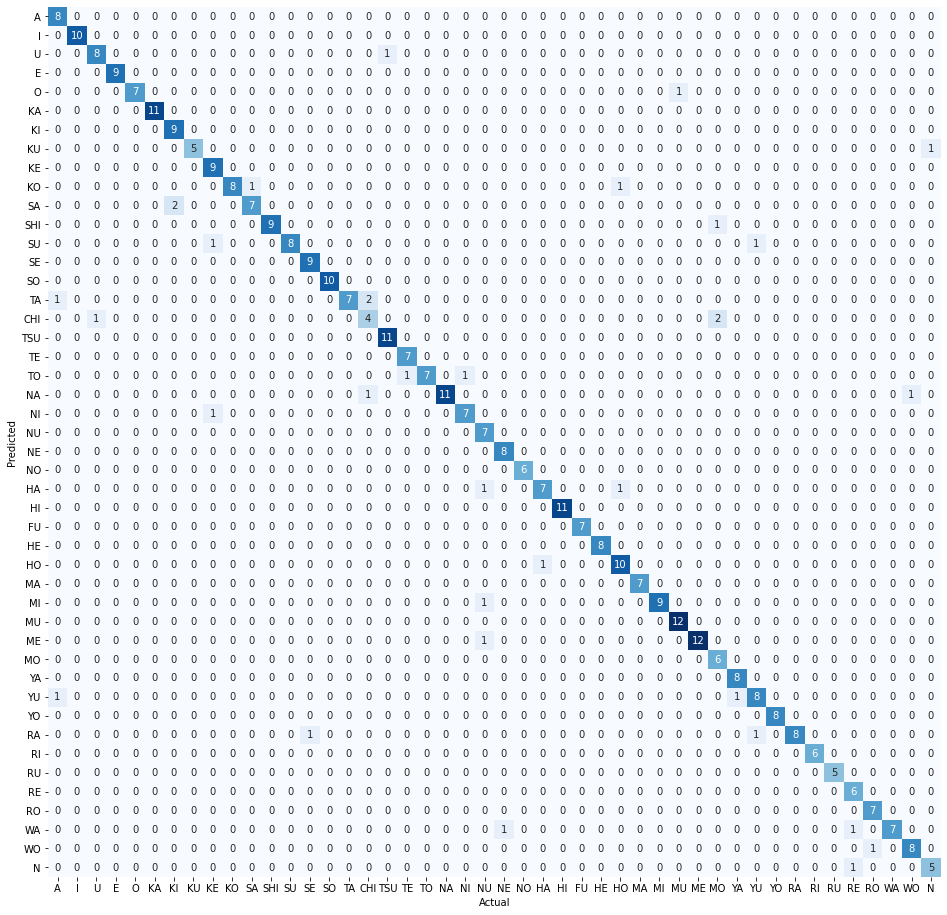

In [13]:
plt.figure(figsize=(16, 16))
sns.heatmap(cm,
            annot=True,
            cbar=False,
            cmap="Blues",
            xticklabels=list(ENCODER.keys()),
            yticklabels=list(ENCODER.keys()),
           )
plt.xticks(rotation=0)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [14]:
# model.save("../kana.model")